In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np

In [14]:
df = pd.read_parquet('../final_data/final_data_v1.parquet').drop(['timestamp','location'],axis=1)

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)

train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

print(train_df)

         lat     lon     P1     P2  humidity  temperature     P0   Day sin  \
50407 -1.292  36.821  10.00   9.00      63.7         25.1   7.00  0.594823   
50412 -1.292  36.821   8.00   8.00      63.1         24.5   7.00  0.584250   
67637 -1.292  36.821   5.50   5.50      64.3         25.3   4.00  0.354291   
67642 -1.292  36.821   4.60   4.00      63.2         25.6   3.00  0.346117   
67647 -1.292  36.821   6.40   6.40      66.8         24.8   3.40  0.333807   
...      ...     ...    ...    ...       ...          ...    ...       ...   
17617 -1.270  36.801  26.75  23.25      47.0         23.6  14.75 -0.923880   
17621 -1.270  36.801  26.00  26.00      47.3         23.6  14.40 -0.928810   
17628 -1.270  36.801  23.50  23.50      47.9         23.5  16.00 -0.938191   
17632 -1.270  36.801  33.25  31.25      48.2         23.4  17.50 -0.941176   
17641 -1.270  36.801  26.40  23.60      48.8         23.3  13.60 -0.949699   

       Year sin  
50407  0.948590  
50412  0.948579  
67637  0.

In [15]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std



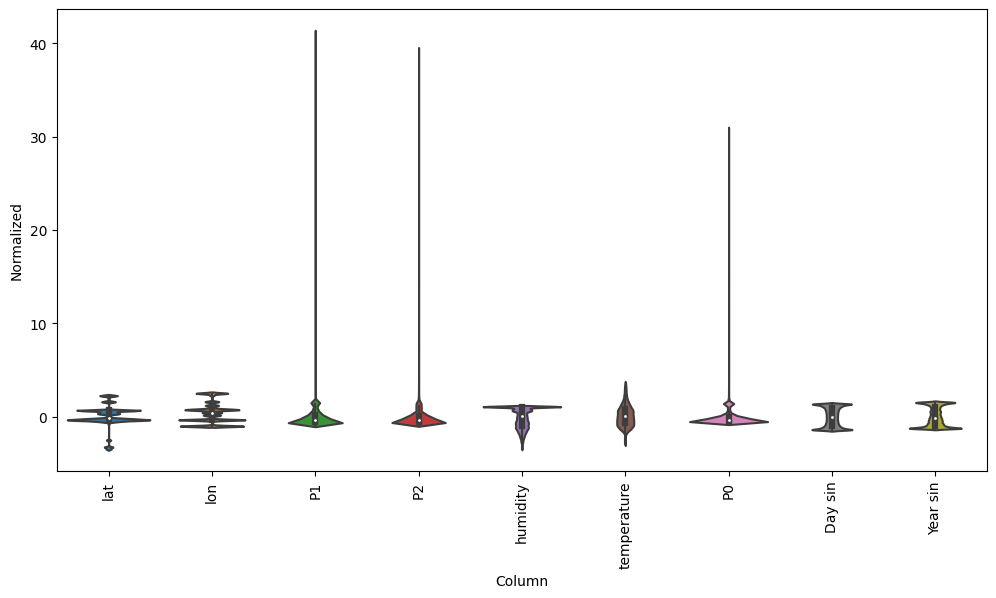

In [16]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])